In [8]:
# 向量化（vectorize）

from my_weapon import *
from gensim.models import Word2Vec
import word2vecReader

count    2.425314e+06
mean     1.650435e+01
std      5.510423e+00
min      1.000000e+00
25%      1.300000e+01
50%      1.700000e+01
75%      2.000000e+01
max      1.110000e+02
dtype: float64


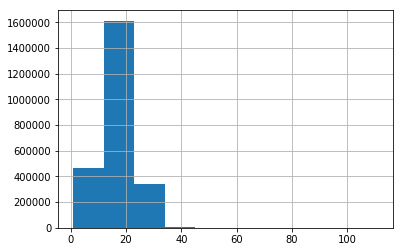

In [78]:
# 统计最长的序列

d = pd.Series([len(line.strip().split(" ")) for line in open("data/train.txt")])
print(d.describe())
d.hist()
plt.show()

In [67]:
wv_model = Word2Vec.load("model/word2vec.mod")

最长的序列是111个tokens，我决定用40作为每个句子的长度

In [70]:
# update vectorize
# 需要经过tweet_process.py的处理

def vectorize(line):
    v = np.zeros(40 * 400).reshape(40, 400)
    words = line.strip().split(" ")
    _index = 0
    for w in words:
        if _index >= 40:
            break
        if w in wv_model.wv:
            v[_index] = wv_model.wv[w]
            _index += 1
    return v

In [71]:
vectorize("what are you doing ?")

array([[-2.08587575,  0.41580471, -2.2741425 , ..., -0.0125636 ,
         2.06250668,  0.08311198],
       [-0.81667441,  0.94962615, -1.45155382, ...,  0.22324868,
         1.16281199, -0.71577537],
       [-0.68626755,  0.78144592, -2.61305523, ...,  0.71367294,
         0.76811117,  2.10258842],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

接下来我们看看另外一个已经训练好的在大的数据集上的word2vec model

location: /media/alex/data/word2vec_twitter_model/

In [72]:
!ls /media/alex/data/word2vec_twitter_model/

README	word2vecReader.py  word2vecReaderUtils.py  word2vec_twitter_model.bin


In [73]:
!cat /media/alex/data/word2vec_twitter_model/README

This zip contains a word2vec model trained on Twitter data as described in:

Godin, F., Vandersmissen, B., De Neve, W., & Van de Walle, R. (2015).
Multimedia Lab @ ACL W-NUT NER shared task: Named entity recognition for Twitter microposts using distributed word representations.
Workshop on Noisy User-generated Text, ACL 2015.

Please cite the paper if you use the model.

This zip contains 2 additional files to read the word2vec model with Python.
The code for this was extracted from the Gensim Library which can be found here: https://radimrehurek.com/gensim/models/word2vec.html
The only difference is that it does not use a strict encoding to read the model from the file.
(One can easily integrate, inherit or extend the library or the Python files)

In [74]:


wv_model2 = word2vecReader.Word2Vec.load_word2vec_format("/media/alex/data/word2vec_twitter_model/word2vec_twitter_model.bin", binary=True)

In [75]:
wv_model2["love"].shape

(400,)

In [78]:
def vectorize_2(line):
    v = np.zeros(40 * 400).reshape(40, 400)
    words = line.strip().split(" ")
    _index = 0
    for w in words:
        if _index >= 40:
            break
        if w in wv_model2:
            v[_index] = wv_model2[w]
            _index += 1
    return v

In [79]:
vectorize_2("i love you so much")

array([[-0.03832966,  0.00200333, -0.04462779, ...,  0.0044597 ,
         0.02114136, -0.02238772],
       [ 0.04128342,  0.07181156,  0.00676483, ..., -0.00052616,
         0.01673744,  0.01691386],
       [-0.01901733,  0.00757742,  0.00171131, ...,  0.05948232,
         0.0217214 , -0.00660098],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# batch=10, in_channels=2, height(num of tokens)=20, width(length of word2vec)=400
_in = torch.randn(10, 2, 40, 400)


# in_channels=2, out_channels=32, kernel_size=(3, 400)
tmp_mod = torch.nn.Conv2d(2, 64, kernel_size=(3, 400), groups=2)

_out = tmp_mod(_in)
print("conv1:", _out.size())

_out = F.relu(_out)
print("relu:", _out.size())

_out = torch.squeeze(_out)
print("squeeze:", _out.size())

_out = F.max_pool1d(_out, 2)
print("max_pool1d:", _out.size())

_out = _out.view(-1, 2 * 32 * 19)
print("flat:", _out.size())

f1 = nn.Linear(1216, 64)
_out = f1(_out)
_out = F.relu(_out)
print("f1:", _out.size())

f2 = nn.Linear(64, 32)
_out = f2(_out)
_out = F.relu(_out)
print("f2:", _out.size())

f3 = nn.Linear(32, 1)
_out = f3(_out)
# _out = F.relu(_out)
print("f3:", _out.size())

probs = F.softmax(_out, 1)
print(probs)
torch.max(probs, 1)[1]
    


conv1: torch.Size([10, 64, 38, 1])
relu: torch.Size([10, 64, 38, 1])
squeeze: torch.Size([10, 64, 38])
max_pool1d: torch.Size([10, 64, 19])
flat: torch.Size([10, 1216])
f1: torch.Size([10, 64])
f2: torch.Size([10, 32])
f3: torch.Size([10, 1])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SoftmaxBackward>)


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [30]:
_in = torch.randn(10, 2, 40, 400)
model = CNNClassifier()
model(_in)

(tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]], grad_fn=<SoftmaxBackward>),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [97]:
# make train dataset

import random

with open("data/train_dataset.txt", "w") as f:
    lines = []
    for line in open("data/0-train.txt"):
        lines.append("0\t{}".format(line))
    for line in open("data/1-train.txt"):
        lines.append("1\t{}".format(line))
    random.shuffle(lines)
    
    for line in lines:
        f.write(line)

In [96]:
class Config:
    def __init__(self):
        self.train_file = "data/train_dataset.txt"
        self.train_batch_size = 128
        
        self.learning_rate = 0.001
        self.window_size = 3
        self.num_classes = 2
        
        self.num_epochs = 10
        self.train_steps = None
        
        self.summary_interval = 100
        
config = Config()

In [97]:
class Dataset:
    def __init__(self, filepath, batch_size):
        self._file = open(filepath)
        self._wv1 = self.read_wv1()
        self._wv2 = self.read_wv2()
        self._batch_size = batch_size
        self._reset()

    def read_wv1(self):
        return Word2Vec.load("model/word2vec.mod")
        
    def read_wv2(self):
        return word2vecReader.Word2Vec.load_word2vec_format(
            "/media/alex/data/word2vec_twitter_model/word2vec_twitter_model.bin", binary=True)

    def wv1(self, line):
        v = np.zeros(40 * 400).reshape(40, 400)
        words = line.strip().split(" ")
        _index = 0
        for w in words:
            if _index >= 40:
                break
            if w in self._wv1.wv:
                v[_index] = self._wv1.wv[w]
                _index += 1
        return v

    def wv2(self, line):
            v = np.zeros(40 * 400).reshape(40, 400)
            words = line.strip().split(" ")
            _index = 0
            for w in words:
                if _index >= 40:
                    break
                if w in self._wv2:
                    v[_index] = self._wv2[w]
                    _index += 1
            return v

    def _fill_buffer(self, size):
        if not self._buffer:
            for line in self._file:
                label, sentence = line.split("\t")
                label = int(label.strip())
                sequence1 = self.wv1(sentence)
                sequence2 = self.wv2(sentence)
                self._buffer.append((label, [sequence1, sequence2]))
                if len(self._buffer) >= size:
                    break
            self._buffer_iter = iter(self._buffer)

    def __iter__(self):
        self._reset()
        return self

    def __next__(self):
        self._fill_buffer(self._batch_size * 1000)

        label_batch = []
        sequence_batch = []
        for label, sequence in self._buffer_iter:
            label_batch.append(label)
            sequence_batch.append(sequence)
            if len(label_batch) == self._batch_size:
                break

        if not label_batch:
            raise StopIteration

        return {"sequences": np.array(sequence_batch), "labels": label_batch, }

    def _reset(self):
        self._file.seek(0)
        self._buffer = []
        self._buffer_iter = None

train_set = Dataset(config.train_file, config.train_batch_size)

INFO	2018-11-26 14:35:58,028	loading Word2Vec object from model/word2vec.mod
INFO	2018-11-26 14:35:58,526	loading wv recursively from model/word2vec.mod.wv.* with mmap=None
INFO	2018-11-26 14:35:58,526	loading vectors from model/word2vec.mod.wv.vectors.npy with mmap=None
INFO	2018-11-26 14:36:00,030	setting ignored attribute vectors_norm to None
INFO	2018-11-26 14:36:00,030	loading vocabulary recursively from model/word2vec.mod.vocabulary.* with mmap=None
INFO	2018-11-26 14:36:00,031	loading trainables recursively from model/word2vec.mod.trainables.* with mmap=None
INFO	2018-11-26 14:36:00,031	loading syn1neg from model/word2vec.mod.trainables.syn1neg.npy with mmap=None
INFO	2018-11-26 14:36:01,525	setting ignored attribute cum_table to None
INFO	2018-11-26 14:36:01,526	loaded model/word2vec.mod


In [98]:
for tmp in train_set:
    print(tmp["sequences"].shape)
    break

(128, 2, 40, 400)


In [99]:
import torch
from torch import autograd, optim, nn


class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()

        # 2 in- channels, 32 out- channels, 3 * 400 windows size
        self.conv = torch.nn.Conv2d(2, 64, kernel_size=(3, 400), groups=2) 
        self.f1 = nn.Linear(1216, 64)
        self.f2 = nn.Linear(64, 32)
        self.f3 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.conv(x)
        out = F.relu(out)
        out = torch.squeeze(out)
        out = F.max_pool1d(out, 2)
        out = out.view(-1, 2 * 32 * 19) # 9 is after pooling
        out = F.relu(self.f1(out))
        out = F.relu(self.f2(out))
        out = self.f3(out)
        # print(out.size())
        
        probs = F.softmax(out, dim=1)
        # print(probs)
        classes = torch.max(probs, 1)[1]

        return probs, classes
    


In [104]:
logging.basicConfig(format="%(levelname)s\t%(asctime)s\t%(message)s", level=logging.INFO)
import logging
from tensorboardX import SummaryWriter


def train():

    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    writer = SummaryWriter(log_dir="log")


    epoch = 0
    step = 0


    for epoch in range(1, config.num_epochs + 1):
        logging.info("==================== Epoch: {} ====================".format(epoch))
        running_losses = []
        for batch in train_set:

            sequences = torch.Tensor(batch["sequences"])
            labels = torch.LongTensor(batch["labels"])

            # Predict
            probs, classes = model(sequences)

            # Backpropagation
            optimizer.zero_grad()
            losses = loss_function(probs, labels)
            losses.backward()
            optimizer.step()

            # Log summary
            running_losses.append(losses.data.item())
            if step % config.summary_interval == 0:
                loss = sum(running_losses) / len(running_losses)
                writer.add_scalar("train/loss", loss, step)
                logging.info("step = {}, loss = {}".format(step, loss))
                running_losses = []

            step += 1

        epoch += 1
        
model = CNNClassifier()
train()

INFO	2018-11-26 14:57:06,862	==================== Epoch: 1 ====================
INFO	2018-11-26 14:57:17,450	step = 0, loss = 0.6983174681663513
INFO	2018-11-26 14:57:26,453	step = 100, loss = 0.6350847744941711
INFO	2018-11-26 14:57:35,162	step = 200, loss = 0.597502669095993
INFO	2018-11-26 14:57:43,285	step = 300, loss = 0.5649592766165733
INFO	2018-11-26 14:57:52,235	step = 400, loss = 0.5579814839363099
INFO	2018-11-26 14:58:01,308	step = 500, loss = 0.5507378333806991
INFO	2018-11-26 14:58:09,753	step = 600, loss = 0.5403113803267479
INFO	2018-11-26 14:58:19,162	step = 700, loss = 0.5407187908887863
INFO	2018-11-26 14:58:27,946	step = 800, loss = 0.5406585448980331
INFO	2018-11-26 14:58:37,447	step = 900, loss = 0.5351702859997749
INFO	2018-11-26 14:58:45,922	==================== Epoch: 2 ====================
INFO	2018-11-26 14:58:55,914	step = 1000, loss = 0.5216349363327026
INFO	2018-11-26 14:59:05,571	step = 1100, loss = 0.5293188491463661
INFO	2018-11-26 14:59:13,462	step = 1